In [1]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error,confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import keras
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, Dropout, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.layers import BatchNormalization
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras.backend as K


2024-05-14 22:49:04.012406: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 22:49:04.052928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 22:49:04.052989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 22:49:04.053977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 22:49:04.060184: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 22:49:04.060722: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
parameter_data = pd.read_csv('../02_machine_learning/parameter_data_lead_time_also_FZ.csv')
parameter_data.drop(columns=['airport_id'], inplace=True)
parameter_data['airport_id'] = pd.factorize(parameter_data['airport'])[0]

In [3]:
# For analyzis in dataframe only
parameter_data['time'] = pd.to_datetime(parameter_data['time'])

# Sort the DataFrame by 'timestamp' in ascending order
# Shift the 'metar' column by one hour
parameter_data['metar_lead_1'] = parameter_data['metar'].shift(-1)
parameter_data['metar_lead_2'] = parameter_data['metar'].shift(-2)

In [4]:
parameter_data

,Unnamed: 0,airport,time,contain_FZ,metar,metartype,air_temperature_0m,air_temperature_2m,relative_humidity_2m,precipitation_amount_acc,...,liquid_water_content_of_surface_snow_lead_4,liquid_water_content_of_surface_snow_lead_5,contain_FZ_lead_1,contain_FZ_lead_2,contain_FZ_lead_3,contain_FZ_lead_4,contain_FZ_lead_5,airport_id,metar_lead_1,metar_lead_2
0,0,ENAL,2021-01-01 01:00:00,False,ENAL 010120Z 08005KT 9999 FEW027/// SCT040/// ...,AUTO,5.98,2.12,0.809798,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010150Z 09006KT 9999 BKN025/// M01/M02 Q1...,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=
1,1,ENAL,2021-01-01 02:00:00,False,ENAL 010150Z 09006KT 9999 BKN025/// M01/M02 Q1...,AUTO,5.84,1.90,0.826657,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=
2,2,ENAL,2021-01-01 03:00:00,False,ENAL 010320Z 09006KT 9999 OVC025/// 01/M02 Q1006=,AUTO,5.79,1.63,0.865065,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=
3,3,ENAL,2021-01-01 04:00:00,False,ENAL 010420Z 17003KT 9999 OVC028/// 01/M01 Q1006=,AUTO,5.81,1.67,0.869259,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=,ENAL 010550Z 14008KT 9999 OVC030/// 02/M02 Q1006=
4,4,ENAL,2021-01-01 05:00:00,False,ENAL 010520Z 14006KT 9999 OVC031/// 02/M01 Q1006=,AUTO,5.99,2.06,0.839891,0.000000,...,0.0,0.0,False,False,False,False,False,0,ENAL 010550Z 14008KT 9999 OVC030/// 02/M02 Q1006=,ENAL 010650Z 14006KT 9999 OVC025/// 02/M01 Q1006=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555308,555308,ENZV,2023-12-31 19:00:00,False,ENZV 311850Z 09018G29KT CAVOK 05/M04 Q0994=,MANUAL,1.45,2.29,0.667786,0.000810,...,0.0,0.0,False,False,False,False,False,53,ENZV 311950Z 10017KT CAVOK 05/M04 Q0994=,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=
555309,555309,ENZV,2023-12-31 20:00:00,False,ENZV 311950Z 10017KT CAVOK 05/M04 Q0994=,MANUAL,1.34,2.23,0.669755,0.005201,...,0.0,0.0,False,False,False,False,False,53,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=
555310,555310,ENZV,2023-12-31 21:00:00,False,ENZV 312050Z 10018KT CAVOK 05/M04 Q0994=,MANUAL,1.11,2.02,0.669258,0.015085,...,0.0,0.0,False,False,False,False,False,53,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=,ENZV 312250Z 10021KT CAVOK 05/M04 Q0994=
555311,555311,ENZV,2023-12-31 22:00:00,False,ENZV 312220Z 10023G34KT CAVOK 05/M05 Q0994=,MANUAL,0.85,1.80,0.660101,0.023475,...,0.0,0.0,False,False,False,False,False,53,ENZV 312250Z 10021KT CAVOK 05/M04 Q0994=,None


In [5]:
# Train test split
X_train, X_test = train_test_split(parameter_data, test_size = 0.2, random_state=9)

### Downsampling the occurrences of FALSE for contain_FZ

In [6]:
downsampling_percentage = 0.01

fz_majority = X_train[X_train['contain_FZ'] == False]
fz_minority = X_train[X_train['contain_FZ'] == True]

print(f'Size of majority: {fz_majority.shape}')
print(f'Size of minority: {fz_minority.shape}')

majority_size = int(len(fz_majority) * downsampling_percentage)

# Downsample the majority class to match the minority class
downsampled_majority = resample(fz_majority, replace=False, n_samples=majority_size, random_state=42)
print(f'Size of downsampled majority: {downsampled_majority.shape}')

# Combine the downsampled majority class with the original minority class
downsampled_X_train = pd.concat([downsampled_majority, fz_minority])

Size of majority: (440007, 129)
Size of minority: (4243, 129)
Size of downsampled majority: (4400, 129)


In [7]:
X_train_downsampled = downsampled_X_train.drop(['contain_FZ'], axis=1)
X_train_fz = downsampled_X_train['contain_FZ']
y_train = downsampled_X_train[['contain_FZ_lead_2']]
y_test = X_test['contain_FZ_lead_2']
X_test_fz = X_test['contain_FZ']
#X_test = X_test.drop(['contain_FZ'], axis=1)

In [8]:
fz_majority_test = X_test[X_test['contain_FZ'] == False]
fz_minority_test = X_test[X_test['contain_FZ'] == True]
print(f'Size of majority in test dataset: {fz_majority_test.shape}')
print(f'Size of minority in test dataset: {fz_minority_test.shape}')

Size of majority in test dataset: (109993, 129)
Size of minority in test dataset: (1070, 129)


## F1-score 

In [9]:
def f1_score_calc(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Standardize features

In [10]:
data_params = ['air_temperature_0m', 'air_temperature_2m', 'relative_humidity_2m', 'x_wind_10m', 'y_wind_10m', 'fog_area_fraction', 'surface_air_pressure', 
               'air_pressure_at_sea_level', 'precipitation_amount_calculated',
              'air_temperature_pl_850', 'x_wind_pl_850', 'y_wind_pl_850', 'air_temperature_pl_925', 'x_wind_pl_925', 'y_wind_pl_925',
              'liquid_water_content_of_surface_snow']


In [11]:
data_params_lead_time = [f'{param}_lead_{lead_time}' for param in data_params for lead_time in range(1,3)]

In [12]:
data_params_lead_time

['air_temperature_0m_lead_1',
 'air_temperature_0m_lead_2',
 'air_temperature_2m_lead_1',
 'air_temperature_2m_lead_2',
 'relative_humidity_2m_lead_1',
 'relative_humidity_2m_lead_2',
 'x_wind_10m_lead_1',
 'x_wind_10m_lead_2',
 'y_wind_10m_lead_1',
 'y_wind_10m_lead_2',
 'fog_area_fraction_lead_1',
 'fog_area_fraction_lead_2',
 'surface_air_pressure_lead_1',
 'surface_air_pressure_lead_2',
 'air_pressure_at_sea_level_lead_1',
 'air_pressure_at_sea_level_lead_2',
 'precipitation_amount_calculated_lead_1',
 'precipitation_amount_calculated_lead_2',
 'air_temperature_pl_850_lead_1',
 'air_temperature_pl_850_lead_2',
 'x_wind_pl_850_lead_1',
 'x_wind_pl_850_lead_2',
 'y_wind_pl_850_lead_1',
 'y_wind_pl_850_lead_2',
 'air_temperature_pl_925_lead_1',
 'air_temperature_pl_925_lead_2',
 'x_wind_pl_925_lead_1',
 'x_wind_pl_925_lead_2',
 'y_wind_pl_925_lead_1',
 'y_wind_pl_925_lead_2',
 'liquid_water_content_of_surface_snow_lead_1',
 'liquid_water_content_of_surface_snow_lead_2']

In [13]:
all_data_params = data_params + data_params_lead_time

#### Standardizing the data

In [14]:
scaler = StandardScaler()

X_train_downsampled[all_data_params] = scaler.fit_transform(X_train_downsampled[all_data_params])
X_test[all_data_params] = scaler.transform(X_test[all_data_params])

## Embedding layer for airport id

In [15]:
#num_airports = len(parameter_data_embed['airport_id'].unique())
num_airports = len(parameter_data['airport_id'].unique())
print(f'Number of airports: {num_airports}')
input_aid = Input(shape=(1,))
output_dim = 20

embedding_layer = Embedding(input_dim=num_airports, output_dim=output_dim, name="embedding_airport")(input_aid)
flatten_airports = Flatten()(embedding_layer)

emb_cat = Reshape(target_shape=(output_dim,))(flatten_airports)

Number of airports: 54


## Model: ANN

In [16]:
l1_lambda = 0.002

param_data_obs_dim = Input(shape=16,)
lead_time_data_dim = Input(shape=32,)
contain_fz_obs_dim = Input(shape=1,)

# Concatenate embedded categorical airport feature with param features
concat = Concatenate()([emb_cat, param_data_obs_dim, contain_fz_obs_dim, lead_time_data_dim])

dense_layer_1 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(concat)
batch_norm_1 = BatchNormalization()(dense_layer_1)
#dropout_1 = Dropout(0.2)(batch_norm_1)

dense_layer_2 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer_2)

dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer_3)


#dense_layer_4 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda),activation='relu')(dense_layer_3)

#batch_norm_2 = BatchNormalization()(dense_layer_3)

#dense_layer_3 = Dense(units=64, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_2)
#batch_norm_3 = BatchNormalization()(dense_layer_3)

#dense_layer_4 = Dense(units=32, kernel_initializer='he_uniform', kernel_regularizer=l1(l1_lambda), activation='relu')(batch_norm_3)
#batch_norm_4 = BatchNormalization()(dense_layer_4)

# Output Layer
output_layer = Dense(units=1, activation='sigmoid')(batch_norm_3)

model = Model(inputs=[input_aid, param_data_obs_dim, contain_fz_obs_dim, lead_time_data_dim], outputs=output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_airport (Embeddi  (None, 1, 20)                1080      ['input_1[0][0]']             
 ng)                                                                                              
                                                                                                  
 flatten (Flatten)           (None, 20)                   0         ['embedding_airport[0][0]']   
                                                                                                  
 reshape (Reshape)           (None, 20)                   0         ['flatten[0][0]']         

In [18]:
# Compile the model
ml_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=ml_optimizer, metrics=[f1_score_calc])

In [19]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
history = model.fit([X_train_downsampled['airport_id'], X_train_downsampled[data_params], X_train_fz, X_train_downsampled[data_params_lead_time]], y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2, verbose=1, callbacks=early_stopping)

Epoch 1/100


/home/tonjek/.local/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


217/217 [==============================] - 2s 3ms/step - loss: 3.5711 - f1_score_calc: 0.4299 - val_loss: 3.1210 - val_f1_score_calc: 0.3480
Epoch 2/100
217/217 [==============================] - 0s 2ms/step - loss: 2.3953 - f1_score_calc: 0.4908 - val_loss: 2.3846 - val_f1_score_calc: 0.4377
Epoch 3/100
217/217 [==============================] - 0s 2ms/step - loss: 1.7912 - f1_score_calc: 0.5002 - val_loss: 1.9141 - val_f1_score_calc: 0.4619
Epoch 4/100
217/217 [==============================] - 0s 2ms/step - loss: 1.3822 - f1_score_calc: 0.4873 - val_loss: 1.5828 - val_f1_score_calc: 0.4442
Epoch 5/100
217/217 [==============================] - 0s 2ms/step - loss: 1.0999 - f1_score_calc: 0.4964 - val_loss: 1.3370 - val_f1_score_calc: 0.4928
Epoch 6/100
217/217 [==============================] - 0s 2ms/step - loss: 0.9088 - f1_score_calc: 0.4743 - val_loss: 1.1598 - val_f1_score_calc: 0.4855
Epoch 7/100
217/217 [==============================] - 0s 2ms/step - loss: 0.7867 - f1_score_c

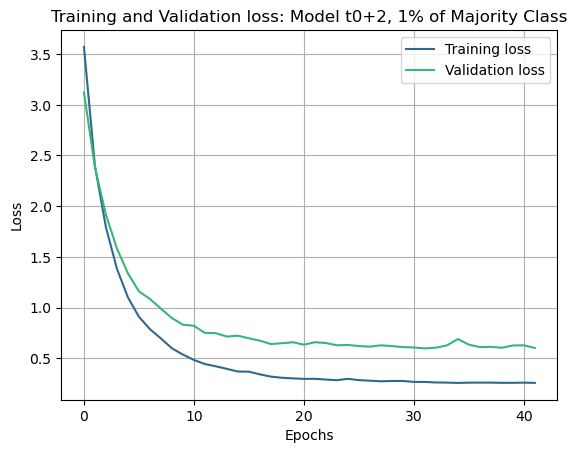

In [21]:
history = pd.DataFrame(history.history)
cmap_loss_val = sns.color_palette('viridis', 2)


plt.plot(history.loc[:, ['loss']], color=cmap_loss_val[0], label='Training loss')
plt.plot(history.loc[:, ['val_loss']], color=cmap_loss_val[1], label='Validation loss')
plt.title('Training and Validation loss: Model t0+2, 1% of Majority Class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.grid(True)

plt.savefig('training_validation_loss_t0+2.png')
plt.show()

## Prediction

In [22]:
# Make predictions
y_pred = model.predict([X_test['airport_id'], X_test[data_params], X_test_fz, X_test[data_params_lead_time]])

3471/3471 [==============================] - 2s 654us/step


In [23]:
y_pred_val = (y_pred > 0.1)
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    109985
        True       0.25      0.43      0.31      1078

    accuracy                           0.98    111063
   macro avg       0.62      0.71      0.65    111063
weighted avg       0.99      0.98      0.98    111063



In [24]:
conf_matrix = confusion_matrix(y_test, y_pred_val)

In [25]:
conf_matrix

array([[108580,   1405],
       [   614,    464]])

In [26]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_val)

In [27]:
f1

0.3148965049202579

## ROC AUC

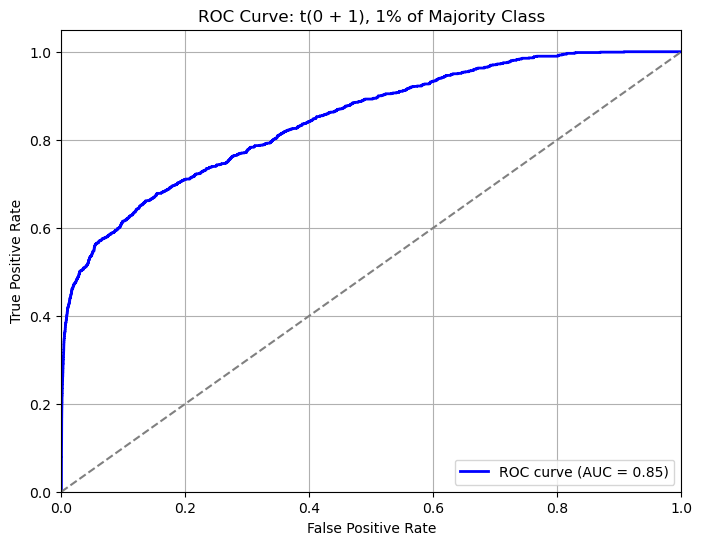

In [28]:

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: t(0 + 1), 1% of Majority Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('rocauc_lead2.png')
plt.show()

In [29]:
# Save y_pred as numpy
#np.save('y_pred_t+2.npy', y_pred)

# Save corresponding y_test
#np.save('y_test_t+2.npy', y_test)

# Analyzation of data
The code from here and forward is for analyzation purposes. 

In [30]:
y_pred = y_pred.flatten()

In [31]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Time': X_test['time'], 'Airport': X_test['airport'], 'Metar': X_test['metar_lead_2'], 'Metartype': X_test['metartype']})

In [32]:
comparison_df.to_csv('comparison.csv', index=False)

In [33]:
pd.set_option('display.max_colwidth', 3000)

In [34]:
comparison_df[comparison_df['Predicted'] > 0.8].head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
182032,True,0.876860,2023-02-06 17:00:00,ENGM,ENGM 061920Z 34002KT 0600 R19R/P2000N R01R/1000U R19L/0700D R01L/0800N FZFG VV002 M07/M08 Q1033=,MANUAL
177458,True,0.802967,2022-01-02 07:00:00,ENGM,ENGM 020850Z 00000KT 0550 R19R/0800N R01R/0500N R19L/0500D R01L/0700N FZFG VV002 M02/M02 Q0998 NOSIG=,MANUAL
177905,True,0.884616,2022-01-23 19:00:00,ENGM,ENGM 232050Z 00000KT 0900 0650E R19R/P2000N R01R/1400U R19L/0900N R01L/0800N FZFG VV002 M05/M05 Q1021 TEMPO 0300=,MANUAL
182033,True,0.892477,2023-02-06 18:00:00,ENGM,ENGM 062020Z 34003KT 0500 R19R/0700D R01R/0600N R19L/0500N R01L/0550N FZFG VV002 M06/M07 Q1033 TEMPO 0300 FZFG=,MANUAL
177411,True,0.858326,2021-12-31 07:00:00,ENGM,ENGM 310850Z VRB02KT 0450 R19R/P2000N R01R/0500N R19L/0400N R01L/0600N FZFG VV002 M04/M05 Q0998 NOSIG=,MANUAL
326069,True,0.812228,2022-11-19 14:00:00,ENNM,ENNM 191620Z 07010KT 040V100 9999 NCD M00/M10 Q1023 REFZRA=,AUTO
177412,True,0.849908,2021-12-31 08:00:00,ENGM,ENGM 310950Z 00000KT 0350 R19R/0650N R01R/0500N R19L/0500N R01L/0500N FZFG VV002 M04/M05 Q0998 TEMPO 0600 FZFG=,MANUAL
182042,True,0.877417,2023-02-07 03:00:00,ENGM,ENGM 070520Z 34003KT 0900 R19R/2000U R01R/1600D R19L/0800N R01L/P2000N FZFG BKN002 M06/M07 Q1030 TEMPO 0500 FZFG=,MANUAL
182064,True,0.852631,2023-02-08 01:00:00,ENGM,ENGM 080250Z VRB02KT 0600 R19R/0800N R01R/0550N R19L/0650N R01L/0800N FZFG VV002 M04/M04 Q1030=,MANUAL
177408,True,0.850144,2021-12-31 04:00:00,ENGM,ENGM 310550Z VRB02KT 0900 R19R/1200U R01R/1100D R19L/0650N R01L/1000U FZFG VV002 M04/M04 Q0997 TEMPO 0500 FZFG=,MANUAL


In [35]:
only_true_fz = comparison_df[comparison_df['Actual'] == True]

In [36]:
only_false_fz = comparison_df[comparison_df['Actual'] == False]

In [37]:
only_true_fz.tail(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
406188,True,0.303591,2021-12-01 00:00:00,ENRY,ENRY 010150Z 05002KT 0100NDV R12/0800V1700 R30/0350V0500N FZFG OVC000/// M10/M12 Q0997=,AUTO
326733,True,0.703823,2022-12-17 18:00:00,ENNM,ENNM 172020Z 06014KT 9999 -FZRA NCD M12/M14 Q1008=,AUTO
182060,True,0.837323,2023-02-07 21:00:00,ENGM,ENGM 072250Z 34003KT 0600 R19R/0900N R01R/0700N R19L/0700U R01L/0750N FZFG VV002 M03/M03 Q1030=,MANUAL
503826,True,0.703351,2022-03-08 23:00:00,ENTO,ENTO 090120Z VRB03KT 0550 R18/1700D R36/P2000N FZFG VV002 M02/M02 Q1026=,AUTO
330736,True,0.571694,2023-11-14 02:00:00,ENNM,ENNM 140420Z 11009KT 060V170 9999 NCD M01/M10 Q1007 REFZRA=,AUTO
135558,True,0.509567,2021-02-16 04:00:00,ENDU,ENDU 160550Z 00000KT 0350 R10/P2000N R28/0600N FZFG BKN001 M09/M10 Q1020 TEMPO 0800 FZFG VV002 RMK WIND 1100FT 13004KT WIND 2200FT 12010KT=,MANUAL
28421,True,0.013964,2021-11-20 03:00:00,ENAT,ENAT 200450Z 00000KT 9999 -FZDZ FEW013/// BKN022/// BKN031/// M04/M04 Q0987 RMK WIND 700FT 34016KT=,AUTO
329645,True,0.371574,2023-04-30 04:00:00,ENNM,ENNM 300550Z 17012KT 140V200 5000 FZRA SCT002/// BKN006/// OVC030/// 02/00 Q1005=,AUTO
144486,True,0.536819,2022-12-01 19:00:00,ENDU,ENDU 012120Z 00000KT 0600 R10/P2000D R28/P2000N FZFG VV003 M02/M02 Q1038 RMK WIND 1100FT VRB01KT WIND 2200FT 10004KT=,COR
365893,True,0.140114,2022-12-22 00:00:00,ENRA,ENRA 220220Z VRB01KT 9999 -FZDZ FEW021/// OVC031/// M02/M02 Q0987 RESG=,AUTO


<AxesSubplot: >

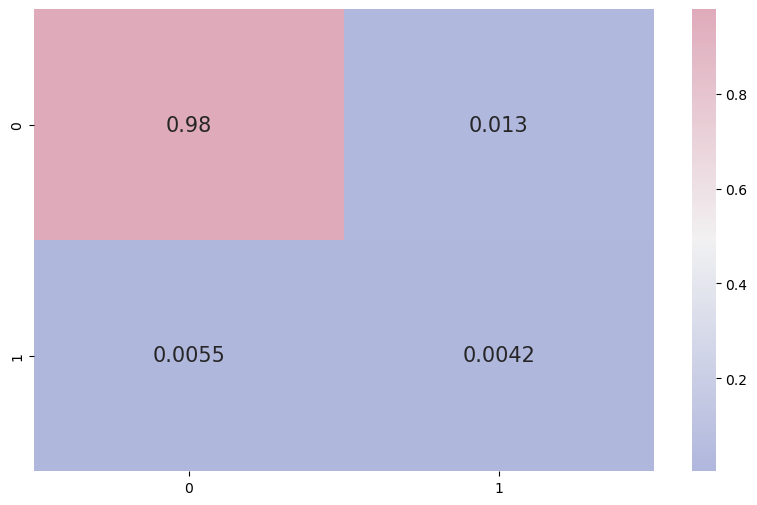

In [38]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(10,6))
cf_matrix = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

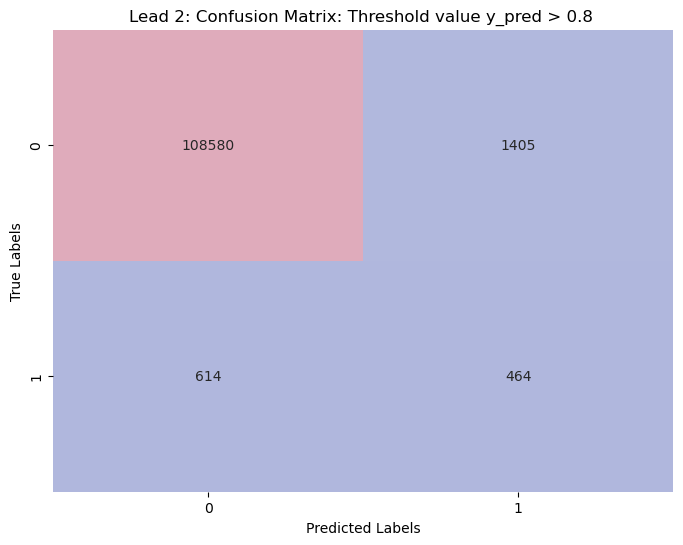

In [39]:

conf_matrix = confusion_matrix(y_test, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap1, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lead 2: Confusion Matrix: Threshold value y_pred > 0.8 ')
plt.savefig('cmap_lead2_0.8.png')
plt.show()

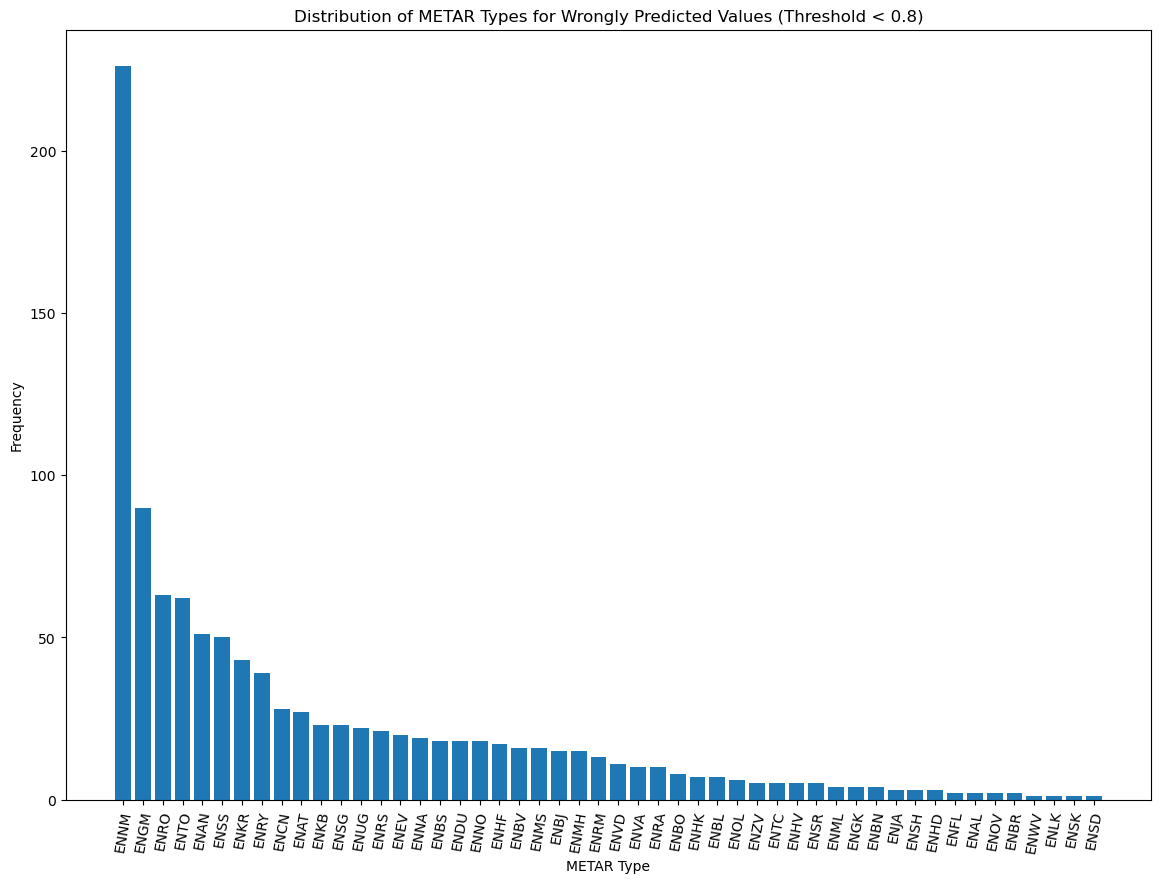

In [40]:
wrongly_predicted_df = only_true_fz[(only_true_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Airport'].value_counts()

plt.figure(figsize=(14, 10))
plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=80)
plt.show()

<Figure size 1400x1000 with 0 Axes>

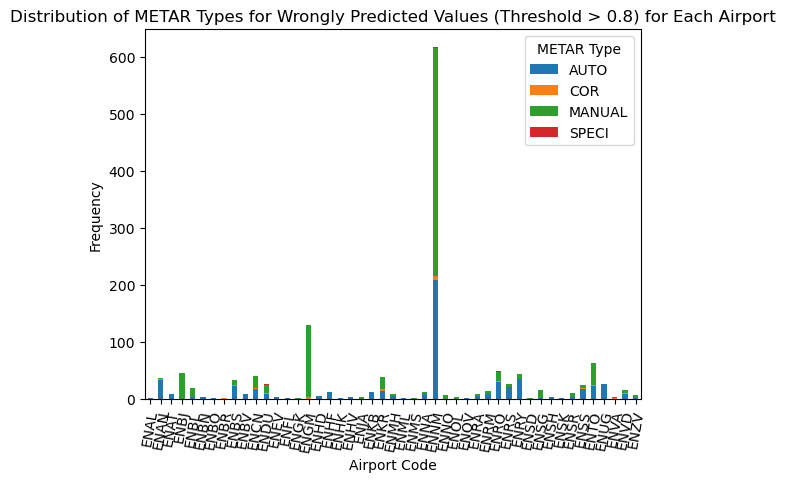

In [48]:
wrongly_predicted_false_df = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.1)]

metar_type_counts_per_airport = wrongly_predicted_false_df.groupby(['Airport', 'Metartype']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 10))  
metar_type_counts_per_airport.plot(kind='bar', stacked=True)
plt.xlabel('Airport Code')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold > 0.8) for Each Airport')
plt.xticks(rotation=80)
plt.legend(title='METAR Type')
plt.show()

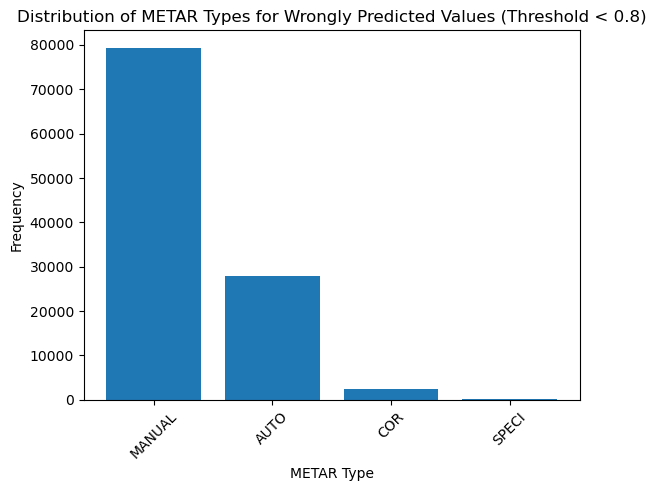

In [49]:
wrongly_predicted_df = only_false_fz[(only_false_fz['Predicted'] < 0.8)]

metar_type_counts = wrongly_predicted_df['Metartype'].value_counts()

plt.bar(metar_type_counts.index, metar_type_counts.values)
plt.xlabel('METAR Type')
plt.ylabel('Frequency')
plt.title('Distribution of METAR Types for Wrongly Predicted Values (Threshold < 0.8)')
plt.xticks(rotation=45)
plt.show()

In [50]:
only_false_fz.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
320059,False,0.009616,2023-10-19 17:00:00,ENNA,ENNA 191850Z 17008KT 9999 FEW039 BKN120 M01/M06 Q1025 RMK WIND 1800FT 26018KT=,MANUAL
514985,False,0.018185,2022-03-26 09:00:00,ENUG,ENUG 261120Z 36029G42KT 9999NDV -SN FEW011/// M05/M10 Q1020 W///S5=,AUTO
445872,False,0.001441,2022-12-03 06:00:00,ENSK,ENSK 030750Z 15013KT 9999 NCD 02/M02 Q1036=,AUTO
490498,False,0.000125,2022-04-20 17:00:00,ENTC,ENTC 201920Z VRB04KT CAVOK 07/02 Q1026 NOSIG RMK WIND 2600FT 23010KT=,MANUAL
183690,False,0.010326,2023-04-26 23:00:00,ENGM,ENGM 270050Z 30004KT 270V340 CAVOK 01/M04 Q1004=,MANUAL
138911,False,0.016600,2021-11-20 16:00:00,ENDU,ENDU 201750Z 27007KT 9999 BKN037/// OVC051/// M02/M04 Q0998 RMK WIND 1100FT 32010KT WIND 2200FT 34013KT=,AUTO
166857,False,0.001186,2021-03-03 20:00:00,ENFL,ENFL 032220Z 35011KT 9999 VCSH FEW020 SCT045 02/M04 Q1026=,MANUAL
404365,False,0.009771,2021-02-16 10:00:00,ENRY,ENRY 161220Z 08004KT 9000 -SN BKN007 OVC011 M01/M03 Q1017 TEMPO 4000 -SG=,MANUAL
395799,False,0.007477,2023-12-30 10:00:00,ENRO,ENRO 301150Z 10005KT 9999 BKN029/// OVC059/// M07/M09 Q0999=,AUTO
296467,False,0.007436,2021-12-19 15:00:00,ENMS,ENMS 191650Z VRB03KT 9999 -SHRA FEW016 BKN024 03/01 Q1020 RMK WIND 412FT VRB03KT=,MANUAL


### Look at characteristics for wrongly predicted True and False

Check the occurrence of SN and RA for predictions over threshold where contain_FZ = FALSE

In [57]:
wrongly_predicted_true = comparison_df[(comparison_df['Actual'] == False) & (comparison_df['Predicted'] >= 0.4)]

filtered_wrongly_predicted_true = wrongly_predicted_true[wrongly_predicted_true['Metar'].str.contains(r'\bRA|\bSN')]


In [58]:
filtered_wrongly_predicted_true

,Actual,Predicted,Time,Airport,Metar,Metartype
326922,False,0.644190,2022-12-25 22:00:00,ENNM,ENNM 260020Z 09015KT 9999 -SN FEW029 SCT045 BKN076 M00/M04 Q0999=,AUTO
181033,False,0.493004,2022-12-26 07:00:00,ENGM,ENGM 260920Z 17006KT 1900 SNRA BKN004 00/00 Q1000 TEMPO 6000 RASN OVC008=,MANUAL
326241,False,0.643223,2022-11-27 06:00:00,ENNM,ENNM 270820Z 10017KT 9999 -RA BKN206 03/M02 Q1017=,AUTO
250868,False,0.503814,2021-11-25 22:00:00,ENKR,ENKR 252350Z VRB01KT 0100 R05/0375N R23/0350N +SN VV001 M18/M20 Q0998 RMK WIND 731FT 07006KT=,MANUAL
327235,False,0.671992,2023-01-07 20:00:00,ENNM,ENNM 072150Z 10021KT 2200 -SN FEW003 BKN019 BKN024 M01/M03 Q0998=,AUTO
144477,False,0.420363,2022-12-01 10:00:00,ENDU,ENDU 011150Z 00000KT 4000 -SN BR OVC006 M02/M02 Q1036 TEMPO 2000 BR VV004 RMK WIND 1100FT 21002KT WIND 2200FT 31005KT=,COR
326886,False,0.456206,2022-12-24 04:00:00,ENNM,ENNM 240620Z 20014KT 170V230 1200 R07/1400 -SN SCT002 BKN024 OVC039 M01/M03 Q1002=,AUTO
326800,False,0.593496,2022-12-20 13:00:00,ENNM,ENNM 201450Z 06011KT 9999 -RASN FEW002 SCT010 BKN016 00/M01 Q0995=,MANUAL
376049,False,0.451487,2023-01-08 00:00:00,ENRM,ENRM 080150Z 10013KT 080V140 8000 -RA NCD 02/00 Q0993=,AUTO
328495,False,0.430620,2023-03-04 17:00:00,ENNM,ENNM 041850Z 27009KT 250V320 1700 -SN BKN001/// BKN028/// OVC035/// M00/M02 Q1008=,AUTO


Look at characteristics for wrongly predicted false

In [59]:
wrongly_predicted_false = comparison_df[(comparison_df['Actual'] == True) & (comparison_df['Predicted'] <= 0.4)]

filtered_wrongly_predicted_false = wrongly_predicted_false[wrongly_predicted_false['Metar'].str.contains(r'\bRA|\bSN')]


In [60]:
filtered_wrongly_predicted_false.head(50)

,Actual,Predicted,Time,Airport,Metar,Metartype
468899,True,0.015743,2022-12-13 20:00:00,ENSS,ENSS 132220Z 10024KT 1100 R33/P2000 -SN FEW007 BKN010 BKN018 M01/M01 Q1000 REFZDZ RMK WIND 0500FT 08039KT=,MANUAL
238224,True,0.010997,2021-12-01 01:00:00,ENKB,ENKB 010320Z 00000KT 0500 R07/P2000N R25/1600N SN VV004 M01/M02 Q0994 REFZUP RMK WIND 745FT 23006KT=,AUTO
37455,True,0.016534,2023-05-03 23:00:00,ENAT,ENAT 040050Z 35014KT 9999 -SN FEW023/// SCT039/// BKN049/// M01/M07 Q1025 REFZUP RMK WIND 700FT 35019KT=,AUTO
470093,True,0.004024,2023-02-06 16:00:00,ENSS,ENSS 061820Z 22032KT 4000 -SN VV012 M01/M02 Q1008 REFZDZ RMK WIND 0500FT 23040KT=,MANUAL
119119,True,0.005764,2022-12-27 15:00:00,ENBV,ENBV 271650Z VRB09KT 9999 -SN NCD M07/M10 Q0996 REFZDZ=,AUTO
507339,True,0.017385,2023-03-13 04:00:00,ENTO,ENTO 130550Z 09005KT 2000 -FZDZ VV004 M00/M00 Q0987 TEMPO 1200 SNRA=,AUTO
240520,True,0.066033,2022-04-04 23:00:00,ENKB,ENKB 050120Z 01003KT 350V050 9999 -SN FEW010/// BKN042/// M01/M04 Q0992 REFZUP RMK WIND 745FT 04008KT=,AUTO
195341,True,0.245806,2021-03-06 18:00:00,ENHF,ENHF 061950Z 06013KT 9999 -SN SCT016/// BKN026/// OVC036/// M04/M06 Q0995 REFZUP RMK WIND 1254FT 07016KT=,AUTO
38052,True,0.012700,2023-10-14 02:00:00,ENAT,ENAT 140350Z 21006KT 9999 -SN OVC012/// M04/M06 Q0994 RESG REFZUP RMK WIND 700FT 17010KT=,AUTO
197912,True,0.017943,2021-11-06 22:00:00,ENHF,ENHF 062350Z 02004KT 3800 -SN VV016 M01/M04 Q1004 RESG REFZUP RMK WIND 1254FT 12002KT=,AUTO
